# Car Price Prediction

In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading a CSV file and explore the dataset
df = pd.read_csv('car_prices.csv')
df.head()

,make,fuel,doors,body,drive,weight,engine-size,bhp,mpg,price
0,alfa-romero,unleaded,two,convertible,rwd,2548,130,111.0,27,13495.0
1,alfa-romero,unleaded,two,convertible,rwd,2548,130,111.0,27,16500.0
2,alfa-romero,unleaded,two,hatchback,rwd,2823,152,154.0,26,16500.0
3,audi,unleaded,four,saloon,fwd,2337,109,102.0,30,13950.0
4,audi,unleaded,four,saloon,4wd,2824,136,115.0,22,17450.0


In [3]:
df.shape

(205, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   make         205 non-null    object 
 1   fuel         205 non-null    object 
 2   doors        203 non-null    object 
 3   body         205 non-null    object 
 4   drive        205 non-null    object 
 5   weight       205 non-null    int64  
 6   engine-size  205 non-null    int64  
 7   bhp          203 non-null    float64
 8   mpg          205 non-null    int64  
 9   price        201 non-null    float64
dtypes: float64(2), int64(3), object(5)
memory usage: 16.1+ KB


In [5]:
df.describe()

,weight,engine-size,bhp,mpg,price
count,205.000000,205.000000,203.000000,205.000000,201.000000
mean,2555.565854,126.907317,104.256158,30.751220,13207.129353
std,520.680204,41.642693,39.714369,6.886443,7947.066342
min,1488.000000,61.000000,48.000000,16.000000,5118.000000
25%,2145.000000,97.000000,70.000000,25.000000,7775.000000
50%,2414.000000,120.000000,95.000000,30.000000,10295.000000
75%,2935.000000,141.000000,116.000000,34.000000,16500.000000
max,4066.000000,326.000000,288.000000,54.000000,45400.000000


In [6]:
columns_with_missing_values = list(df.columns[df.isna().sum() != 0])
print(df.isna().sum())
print(columns_with_missing_values)

make           0
fuel           0
doors          2
body           0
drive          0
weight         0
engine-size    0
bhp            2
mpg            0
price          4
dtype: int64
['doors', 'bhp', 'price']


In [7]:
for i in range(len(columns_with_missing_values)):
    print(df[columns_with_missing_values[i]].dtype)

object
float64
float64


In [8]:
df.doors.unique()

array(['two', 'four', nan], dtype=object)

In [9]:
def handle_doors(x):
    unique_values = df['doors'].unique()
    if len(unique_values) == 1:
        return x 
    elif x == unique_values[0]:
        return 2
    elif x == unique_values[1]:
        return 4
    else:
        return x

df['doors'] = df['doors'].apply(handle_doors)

In [10]:
df.isna().sum()

make           0
fuel           0
doors          2
body           0
drive          0
weight         0
engine-size    0
bhp            2
mpg            0
price          4
dtype: int64

In [11]:
means = [] 
for i in range(len(columns_with_missing_values)):
    means.append(df[columns_with_missing_values[i]].mean())

In [12]:
for i in range(len(columns_with_missing_values)):
    df[columns_with_missing_values[i]].fillna(means[i], inplace = True)
df.isna().sum()

make           0
fuel           0
doors          0
body           0
drive          0
weight         0
engine-size    0
bhp            0
mpg            0
price          0
dtype: int64

<Axes: >

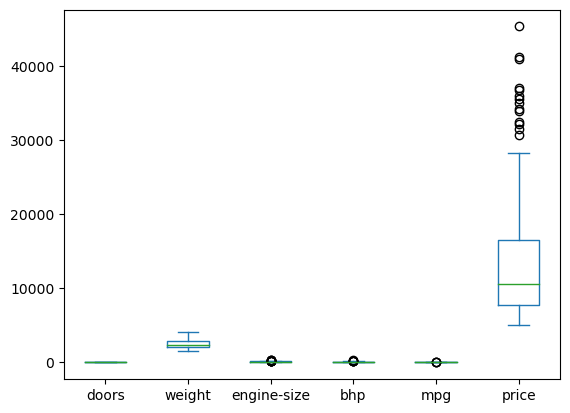

In [13]:
df.plot(kind='box')

<Axes: >

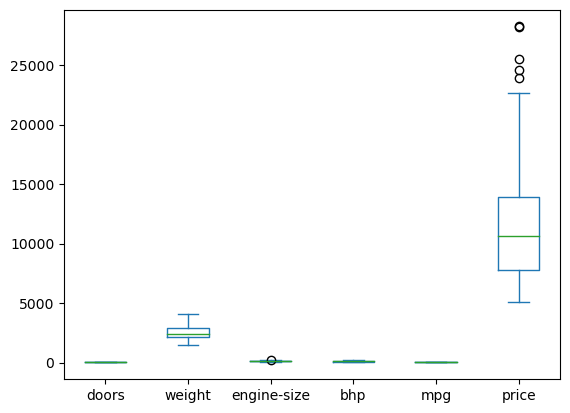

In [14]:
def replace_outliers_with_mean(df, threshold=1.5):
    # Iterate through each numerical column
    for column in df.select_dtypes(include=[np.number]):
        # Calculate the first quartile (Q1) and third quartile (Q3)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        # Calculate the interquartile range (IQR)
        IQR = Q3 - Q1
        # Define the lower and upper bounds for outlier detection
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        # Replace outliers with the mean of the respective column
        outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
        df.loc[outliers_mask, column] = df[column].mean()

    return df

replace_outliers_with_mean(df)

df.plot(kind='box')

In [15]:
categorical_columns = df.select_dtypes(exclude='number').columns
print(categorical_columns)

Index(['make', 'fuel', 'body', 'drive'], dtype='object')


In [16]:
import warnings
warnings.filterwarnings('ignore')

def one_hot_encoder(df, columns):
    encoder = OneHotEncoder(sparse=False)
    encoded_columns = encoder.fit_transform(df[columns])
    df.drop(columns, axis=1, inplace=True)
    for i, col in enumerate(encoder.get_feature_names_out(columns)):
        df[col] = encoded_columns[:, i]
    return df

In [17]:
df = one_hot_encoder(df, categorical_columns)
df.head()

,doors,weight,engine-size,bhp,mpg,price,make_alfa-romero,make_audi,make_bmw,make_chevrolet,...,fuel_diesel,fuel_unleaded,body_convertible,body_hardtop,body_hatchback,body_saloon,body_wagon,drive_4wd,drive_fwd,drive_rwd
0,2.0,2548.0,130.0,111.0,27.0,13495.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.0,2548.0,130.0,111.0,27.0,16500.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.0,2823.0,152.0,154.0,26.0,16500.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,4.0,2337.0,109.0,102.0,30.0,13950.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4.0,2824.0,136.0,115.0,22.0,17450.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   doors               205 non-null    float64
 1   weight              205 non-null    float64
 2   engine-size         205 non-null    float64
 3   bhp                 205 non-null    float64
 4   mpg                 205 non-null    float64
 5   price               205 non-null    float64
 6   make_alfa-romero    205 non-null    float64
 7   make_audi           205 non-null    float64
 8   make_bmw            205 non-null    float64
 9   make_chevrolet      205 non-null    float64
 10  make_dodge          205 non-null    float64
 11  make_honda          205 non-null    float64
 12  make_isuzu          205 non-null    float64
 13  make_jaguar         205 non-null    float64
 14  make_mazda          205 non-null    float64
 15  make_mercedes-benz  205 non-null    float64
 16  make_mer

In [19]:
X = df.drop('price', axis = 1)
y = df[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 123)

In [20]:
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)

In [22]:
model_2 = XGBRegressor()

param_grid = {
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=model_2, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

y_pred_2 = best_model.predict(X_test)

In [50]:
model_3 = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(model_3, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred_3 = best_model.predict(X_test)

In [24]:
# Calculate errors for each model
errors = {
    "Linear Regression": {
        "MAE": mean_absolute_error(y_test, y_pred_1),
        "MSE": mean_squared_error(y_test, y_pred_1),
        "R2": r2_score(y_test, y_pred_1)
    },
    "XGBRegressor": {
        "MAE": mean_absolute_error(y_test, y_pred_2),
        "MSE": mean_squared_error(y_test, y_pred_2),
        "R2": r2_score(y_test, y_pred_2)
    },
    "SVR": {
        "MAE": mean_absolute_error(y_test, y_pred_3),
        "MSE": mean_squared_error(y_test, y_pred_3),
        "R2": r2_score(y_test, y_pred_3)
    }
}

mae_errors = []
mse_errors = []
r2_errors = []

for model, metrics in errors.items():
    mae_errors.append(metrics["MAE"])
    mse_errors.append(metrics["MSE"])
    r2_errors.append(metrics["R2"])

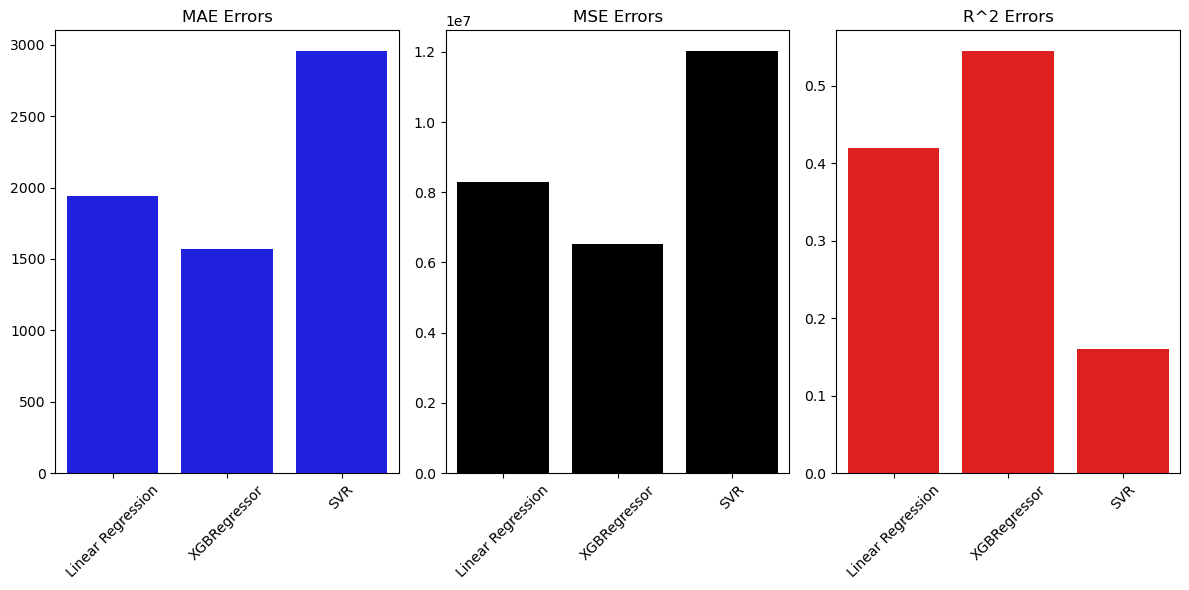

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

sns.barplot(x = list(errors.keys()), y = mae_errors, ax = ax[0], color = 'blue')
ax[0].set_title('MAE Errors')

sns.barplot(x = list(errors.keys()), y = mse_errors, ax = ax[1], color = 'black')
ax[1].set_title('MSE Errors')

sns.barplot(x = list(errors.keys()), y = r2_errors, ax = ax[2], color = 'red')
ax[2].set_title('R^2 Errors')

for axis in ax:
    axis.set_xticklabels(errors.keys(), rotation = 45)

plt.tight_layout()
plt.show()